In [32]:
# %matplotlib inline
%matplotlib widget
#%matplotlib notebook

import numpy as np
import pandas as pd 
import os
from fnmatch import fnmatch
from pathlib import Path

import igor2 as igor
from igor.packed import load as loadpxp
from igor.record.wave import WaveRecord

from Intracellular_analysis_functions import load_NM_data_create_sweeps, create_traces_and_exclude, sweep_number_to_index_array, calculate_FI_curve_properties

from Intracellular_analysis_functions import calculate_input_resistance, sweep_number_to_index_array, offset, remove_stim_artifacts, LowPass_filter, batch_remove_stim_artifacts, create_analysis_windows, get_EPSP_amplitudes 

# Accessing data from google drive

In [33]:
cd /Users/samgritz/Library/CloudStorage/GoogleDrive-gritz122@gmail.com/My Drive/Rutgers/Milstein_Lab_Data/GNB1_WT_Project

/Users/samgritz/Library/CloudStorage/GoogleDrive-gritz122@gmail.com/My Drive/Rutgers/Milstein_Lab_Data/GNB1_WT_Project


In [34]:
google_drive_path = '/Users/samgritz/Library/CloudStorage/GoogleDrive-gritz122@gmail.com/My Drive/Rutgers/Milstein_Lab_Data/GNB1_WT_Project'
google_drive_path = Path(google_drive_path)

# Accessing data from flash drive

This Data has been saved to a flash drive <br>

Files were originally downloaded from box as follows: <br>

 - Make sure to only save .pxp files into CA1_Patch folders that are sweeps - no 0log.pxp or backup.pxp files <br>
 - For example only folders 'Record_CA1_WCc1' can be iterated through <br>

Subfolder organizations: <br>

Project title<br>
> Genotype<br> 
>> CA1_Patch_'date'<br>
>>> Record_CA1_'...rest of file name (this is the file name saved from neuromatic)<br>

In [4]:
# cd /Volumes/PhD_Data/GNB1_WT_Project

### Define Which date, subfolder, and cell you want to export

In [5]:
stimulation_protocols = [b'IV_stim', b'EPSP_stim'] 
path = google_drive_path
dates = ['01042024']  
experiment_subfolder = 'WT_littermates'
cell = 'c1'
data_df = pd.DataFrame(columns=['experiment_index', 'date', 'dir_name', 'file_name', 'cell_number', 'sweep_numbers', 'traces','stim_traces'])
metadata_df = pd.DataFrame(columns=['experiment_index', 'file_name' ,'cell_number',	'stim_type','date',	'inter_trial_interval',	'samples_per_wave',	'experiment_start_time','experiment_end_time',
                                    'total_experiment_time (s)',	'total_experiment_window (ms)',	'dt',	'acquisition_frequency'])

In [6]:
metadata_df 

,file_name,cell_number,stim_type,date,inter_trial_interval,samples_per_wave,experiment_start_time,experiment_end_time,total_experiment_time (s),total_experiment_window (ms),dt,acquisition_frequency


TODO: ONLY PULL OUT ONE CELL at a time and go into each .pxp file and pull out the sweeps of each of the traces....

### Create dataframe structure 

In [29]:
dict_list_data = []
dict_list_metadata = []
exclude_trace_list =  []

for date in dates:
    myDir = Path(f'{google_drive_path}/{experiment_subfolder}/CA1_Patch_{date}') 

    fileNames = [file.name for file in myDir.iterdir() if file.name.startswith('Record_CA1') and file.name.endswith(f'{cell}')]    
    filePaths = [file for file in myDir.iterdir() if file.name.startswith('Record_CA1') and file.name.endswith(f'{cell}')]

    for path in filePaths:
        root = path

        print(f'Loading data from {root}')
        file_pattern = "*.pxp"

        for path, subdirs, files in os.walk(root):
            for i, name in enumerate(files):
                if fnmatch(name, file_pattern):
                    cell_file_path = os.path.join(path, name)


                    row_dict_data = {'experiment_index': name[-7:-4], 'date': date, 'dir_name': cell_file_path, 'file_name': name}
                    row_dict_metadata = {'experiment_index': name[-7:-4], 'file_name': name} 



                    row_dict_data['cell_number'] = cell 
                    row_dict_metadata['cell_number'] = cell

                dict_list_data.append(row_dict_data)
                dict_list_metadata.append(row_dict_metadata)

                for stimulation_set in stimulation_protocols:
                    if stimulation_set == b'IV_stim':
                        try:
                            records_dict, waves_dict, root_waves_dict, experiment_metadata, dt, acquisition_frequency, sweeps, stims =  load_NM_data_create_sweeps(cell_file_path, stimulation_set) 

                            raw_traces, sweep_numbers, excluded_sweep_numbers, excluded_traces = create_traces_and_exclude(sweeps, exclude_trace_list)

                            row_dict_data['sweep_numbers'] = sweep_numbers
                            row_dict_data['traces'] = raw_traces
                            row_dict_data['stim_traces'] = stims

                           #Fill in metadata
                            row_dict_metadata['stim_type'] = stimulation_set
                            row_dict_metadata['date'] = experiment_metadata['date']
                            row_dict_metadata['inter_trial_interval'] = experiment_metadata['inter trial interval (ms)']
                            row_dict_metadata['samples_per_wave'] = experiment_metadata['samples per wave']
                            row_dict_metadata['experiment_start_time'] = experiment_metadata['experiment start time']
                            row_dict_metadata['experiment_end_time'] = experiment_metadata['experiment end time']
                            row_dict_metadata['total_experiment_time (s)'] = experiment_metadata['total experiment time (s)']
                            row_dict_metadata['total_experiment_window (ms)'] = experiment_metadata['total recording window (ms)'] 
                            
                            row_dict_metadata['dt'] = dt
                            row_dict_metadata['acquisition_frequency'] = acquisition_frequency


                        except:
                            pass
                            # print(f'Error loading {cell_file_path}')

                    elif stimulation_set == b'EPSP_stim':
                        try:
                            records_dict, waves_dict, root_waves_dict, experiment_metadata, dt, acquisition_frequency, sweeps, stims =  load_NM_data_create_sweeps(cell_file_path, stimulation_set)

                            raw_traces, sweep_numbers, excluded_sweep_numbers, excluded_traces = create_traces_and_exclude(sweeps, exclude_trace_list)

                            row_dict_data['sweep_numbers'] = sweep_numbers
                            row_dict_data['traces'] = raw_traces
                            row_dict_data['stim_traces'] = stims

                            #Fill in metadata
                            row_dict_metadata['stim_type'] = stimulation_set
                            row_dict_metadata['date'] = experiment_metadata['date']
                            row_dict_metadata['inter_trial_interval'] = experiment_metadata['inter trial interval (ms)']
                            row_dict_metadata['samples_per_wave'] = experiment_metadata['samples per wave']
                            row_dict_metadata['experiment_start_time'] = experiment_metadata['experiment start time']
                            row_dict_metadata['experiment_end_time'] = experiment_metadata['experiment end time']
                            row_dict_metadata['total_experiment_time (s)'] = experiment_metadata['total experiment time (s)']
                            row_dict_metadata['total_experiment_window (ms)'] = experiment_metadata['total recording window (ms)'] 
                            
                            row_dict_metadata['dt'] = dt
                            row_dict_metadata['acquisition_frequency'] = acquisition_frequency
                        except:
                            pass
                            # print(f'Error loading {cell_file_path}')


    
data_df = pd.DataFrame.from_dict(dict_list_data) 
metadata_df = pd.DataFrame.from_dict(dict_list_metadata) 



Loading data from /Users/samgritz/Library/CloudStorage/GoogleDrive-gritz122@gmail.com/My Drive/Rutgers/Milstein_Lab_Data/GNB1_WT_Project/WT_littermates/CA1_Patch_01042024/Record_CA1_WCc1
dict_keys(['K0', 'K1', 'K2', 'K3', 'K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'K10', 'K11', 'K12', 'K13', 'K14', 'K15', 'K16', 'K17', 'K18', 'K19', 'K20', b'FileFormat', b'FileDateTime', b'SamplesPerWave', b'SampleInterval', b'CT_RecordMode', b'NumGrps', b'FileFormatStr', b'FileType', b'FileDate', b'FileTime', b'WavePrefix', b'CurrentPrefix', b'xLabel', b'AcqMode', b'FileFinish', b'CT_TimeStamp', b'CT_TimeIntvl', b'yLabel', b'RecordA0', b'RecordB0', b'RecordA1', b'RecordB1', b'RecordA2', b'RecordB2', b'RecordA3', b'RecordB3', b'RecordA4', b'RecordB4', b'NMPrefix_Record', b'EPSP_stim', b'MultiClampTelegraphs', b'ClampNotes'])
dict_keys(['K0', 'K1', 'K2', 'K3', 'K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'K10', 'K11', 'K12', 'K13', 'K14', 'K15', 'K16', 'K17', 'K18', 'K19', 'K20', b'FileFormat', b'FileDateTime', b'Sampl

In [30]:
data_df

,experiment_index,date,dir_name,file_name,cell_number,sweep_numbers,traces,stim_traces
0,039,01042024,/Users/samgritz/Library/CloudStorage/GoogleDri...,Record_CA1_WC_c1_039.pxp,c1,"[1, 2, 3, 4, 5]","[[-102.484371875572, -98.70723006824282, -95.3...","[[-0.04353447016544759, -0.044848255993706565,..."
1,038,01042024,/Users/samgritz/Library/CloudStorage/GoogleDri...,Record_CA1_WC_c1_038.pxp,c1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[-144.26286609344024, -136.2487493237671, -12...","[[-0.044848255993706565, -0.044848255993706565..."
2,036,01042024,/Users/samgritz/Library/CloudStorage/GoogleDri...,Record_CA1_WC_c1_036.pxp,c1,[1],"[[-74.96051080519322, -73.54818901330003, -72....","[[-0.044848255993706565, -0.044191363079379875..."
3,037,01042024,/Users/samgritz/Library/CloudStorage/GoogleDri...,Record_CA1_WC_c1_037.pxp,c1,[1],"[[-78.14644616385789, -76.40567733320164, -74....","[[-0.044191363079379875, -0.044191363079379875..."
4,035,01042024,/Users/samgritz/Library/CloudStorage/GoogleDri...,Record_CA1_WC_c1_035.pxp,c1,[1],"[[-123.89912967389593, -117.95423422302993, -1...","[[-0.04353447016544759, -0.044191363079379875,..."
5,034,01042024,/Users/samgritz/Library/CloudStorage/GoogleDri...,Record_CA1_WC_c1_034.pxp,c1,[1],"[[-105.93306684299026, -101.56471992846605, -9...","[[-0.044848255993706565, -0.04353447016544759,..."
6,030,01042024,/Users/samgritz/Library/CloudStorage/GoogleDri...,Record_CA1_WC_c1_030.pxp,c1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[[-230.74316880790354, -214.32076474681313, -1...","[[-0.044191363079379875, -0.045505148908427606..."
7,031,01042024,/Users/samgritz/Library/CloudStorage/GoogleDri...,Record_CA1_WC_c1_031.pxp,c1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[[-103.1741108480973, -99.00283245929305, -95....","[[-0.044848255993706565, -0.044191363079379875..."
8,033,01042024,/Users/samgritz/Library/CloudStorage/GoogleDri...,Record_CA1_WC_c1_033.pxp,c1,[1],"[[-92.07259912490437, -88.98519693142507, -86....","[[-0.044191363079379875, -0.044848255993706565..."
9,032,01042024,/Users/samgritz/Library/CloudStorage/GoogleDri...,Record_CA1_WC_c1_032.pxp,c1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[[-90.16760625787042, -87.47434061354683, -84....","[[-0.044848255993706565, -0.04353447016544759,..."


In [31]:
metadata_df

,experiment_index,file_name,cell_number,stim_type,date,inter_trial_interval,samples_per_wave,experiment_start_time,experiment_end_time,total_experiment_time (s),total_experiment_window (ms),dt,acquisition_frequency
0,039,Record_CA1_WC_c1_039.pxp,c1,b'EPSP_stim',"b'Thu, Jan 4, 2024'",20000.0,30000.0,b'2:58:34 PM',b'3:00:23 PM',107.5,1500.0,0.05,20000.0
1,038,Record_CA1_WC_c1_038.pxp,c1,b'EPSP_stim',"b'Thu, Jan 4, 2024'",20000.0,30000.0,b'2:47:31 PM',b'2:58:18 PM',645.0,1500.0,0.05,20000.0
2,036,Record_CA1_WC_c1_036.pxp,c1,b'EPSP_stim',"b'Thu, Jan 4, 2024'",900.0,30000.0,b'2:46:01 PM',b'2:46:05 PM',2.4,1500.0,0.05,20000.0
3,037,Record_CA1_WC_c1_037.pxp,c1,b'EPSP_stim',"b'Thu, Jan 4, 2024'",900.0,30000.0,b'2:46:19 PM',b'2:46:23 PM',2.4,1500.0,0.05,20000.0
4,035,Record_CA1_WC_c1_035.pxp,c1,b'EPSP_stim',"b'Thu, Jan 4, 2024'",900.0,30000.0,b'2:45:45 PM',b'2:45:49 PM',2.4,1500.0,0.05,20000.0
5,034,Record_CA1_WC_c1_034.pxp,c1,b'EPSP_stim',"b'Thu, Jan 4, 2024'",900.0,30000.0,b'2:44:40 PM',b'2:44:44 PM',2.4,1500.0,0.05,20000.0
6,030,Record_CA1_WC_c1_030.pxp,c1,b'IV_stim',"b'Thu, Jan 4, 2024'",900.0,20000.0,b'2:41:20 PM',b'2:41:40 PM',19.0,1000.0,0.05,20000.0
7,031,Record_CA1_WC_c1_031.pxp,c1,b'IV_stim',"b'Thu, Jan 4, 2024'",900.0,20000.0,b'2:42:18 PM',b'2:42:38 PM',19.0,1000.0,0.05,20000.0
8,033,Record_CA1_WC_c1_033.pxp,c1,b'EPSP_stim',"b'Thu, Jan 4, 2024'",900.0,30000.0,b'2:43:53 PM',b'2:43:57 PM',2.4,1500.0,0.05,20000.0
9,032,Record_CA1_WC_c1_032.pxp,c1,b'IV_stim',"b'Thu, Jan 4, 2024'",900.0,20000.0,b'2:43:04 PM',b'2:43:24 PM',19.0,1000.0,0.05,20000.0


{'date': b'Thu, Jan 4, 2024',
 'inter trial interval (ms)': 20000.0,
 'total recording window (ms)': 1500.0,
 'samples per wave': 30000.0,
 'experiment start time': b'2:58:34 PM',
 'experiment end time': b'3:00:23 PM',
 'total experiment time (s)': 107.5}

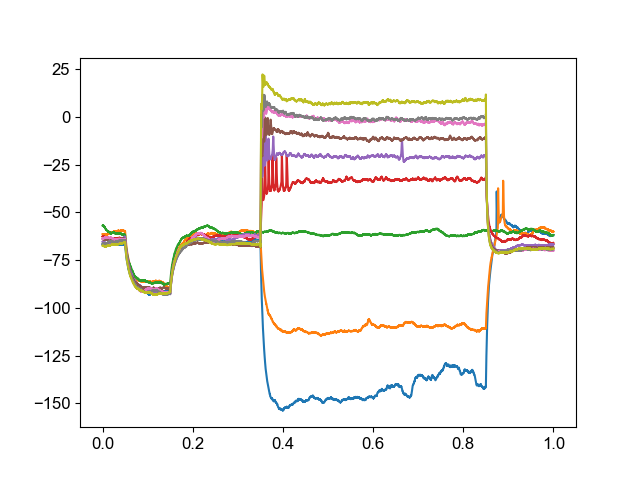

In [133]:
plt.figure()
time = np.arange(0, len(data_df['traces'][10][0])/acquisition_frequency, 1/acquisition_frequency)

try:
    for sweep in data_df['sweep_numbers'][10]:
        plt.plot(time, data_df['traces'][10][sweep])
except:
    pass

In [19]:
string = '_003.pxp'
string[-7:-4]

'003'